In [3]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import json
from tqdm import tqdm
import yaml

#import geopandas as gpd
import pandas as pd

import torch

import sys
sys.path.append('../')

import utils.basics as bsc 
import utils.plotting as pt
import utils.processing as proc
import utils.eval_pipe as eval

import utils.model_loader as md
import utils.data_loader as dt
import utils.config_loader as cf

%load_ext autoreload
%autoreload 2


In [4]:
# SELECT EXPERIMENTAL CONFIG
with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    experiment_names = list(experiments.keys())
    experiment_names = experiment_names[0:7]  # Select the first 6 experiment names

global_config = md.global_config


In [271]:
df_result = pd.DataFrame()
for exp_name in experiment_names:
    sites, cfg = get_config(exp_name)
    global_config = md.global_config
    model_weights, logs, cfg = md.load_results(exp_name)
    preds_val, targets_val, preds_test, targets_test, maskval, masktest = [None] * 6
    preds_val, targets_val, preds_test, targets_test, maskval, masktest = md.load_np_stacks(exp_name)
    report = eval.ziptheresults(exp_name, model_weights, logs, cfg, preds_val, targets_val, preds_test, targets_test, maskval, masktest)
    df_result = eval.write_metrics_to_df(report, sites, global_config, df=df_result)
    print("====================================")
    print("EVAL REPORT FOR EXPERIMENT: ", exp_name)
    #eval.print_all_metrics(report, sites, cfg, above2m=True)
    #eval.plot_error_over_frequency(report, bins=80, title = f"{exp_name} - Error vs. GT Distribution")
    eval.printout_eval_report(report, sites, cfg)
    print("====================================")

    # Print the evaluation report
print(df_result.transpose().to_string())
# Save the transposed DataFrame to a CSV file with optional override
override = False
path = "../results/eval/tables/results_summary.csv"
os.makedirs(os.path.dirname(path), exist_ok=True)

if override:
    df_result.transpose().to_csv(path)
    print("Results saved to", path)
else:
    base, ext = os.path.splitext(path)
    suffix = 1
    new_path = f"{base}_{suffix}{ext}"
    while os.path.exists(new_path):
        suffix += 1
        new_path = f"{base}_{suffix}{ext}"
    df_result.transpose().to_csv(new_path)
    print("Results saved to", new_path)

EVAL REPORT FOR EXPERIMENT:  01_baseline
EVAL REPORT FOR EXPERIMENT:  02_pixel_composites
EVAL REPORT FOR EXPERIMENT:  03_seasonal_composites
EVAL REPORT FOR EXPERIMENT:  04_pixel_and_seasonal_comp
EVAL REPORT FOR EXPERIMENT:  05_support_fmask_dlt
EVAL REPORT FOR EXPERIMENT:  06_support_fmask_dlt_dem
EVAL REPORT FOR EXPERIMENT:  07_aux_task
                                    0                    1                       2                           3                     4                         5                  6
Experiment                01_baseline  02_pixel_composites  03_seasonal_composites  04_pixel_and_seasonal_comp  05_support_fmask_dlt  06_support_fmask_dlt_dem        07_aux_task
MAE [m] (Val)                    3.92                 4.14                    4.01                         3.7                  3.75                       3.7               3.81
MAE [m] (Test)                   4.17                 4.28                     4.0                        3.58             

## 250 again

In [282]:
# SELECT EXPERIMENTAL CONFIG
with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    experiment_names = list(experiments.keys())
    experiment_names = experiment_names[0:7]  # Select the first 6 experiment names

df_result = pd.DataFrame()
for exp_name in experiment_names:
    sites, cfg = get_config(exp_name)
    global_config = md.global_config
    model_weights, logs, cfg = md.load_results(exp_name)
    preds_val, targets_val, preds_test, targets_test, maskval, masktest = [None] * 6
    preds_val, targets_val, preds_test, targets_test, maskval, masktest = md.load_np_stacks(exp_name)
    report = eval.ziptheresults(exp_name, model_weights, logs, cfg, preds_val, targets_val, preds_test, targets_test, maskval, masktest)
    df_result = eval.write_metrics_to_df(report, sites, global_config, df=df_result)
    print("====================================")
    print("EVAL REPORT FOR EXPERIMENT: ", exp_name)
    #eval.print_all_metrics(report, sites, cfg, above2m=True)
    #eval.plot_error_over_frequency(report, bins=80, title = f"{exp_name} - Error vs. GT Distribution")
    eval.printout_eval_report(report, sites, cfg)
    #print("====================================")

    # Print the evaluation report
print(df_result.transpose().to_string())
# Save the transposed DataFrame to a CSV file with optional override
override = False
path = "../results/eval/tables/results_summary.csv"
os.makedirs(os.path.dirname(path), exist_ok=True)

if override:
    df_result.transpose().to_csv(path)
    print("Results saved to", path)
else:
    base, ext = os.path.splitext(path)
    suffix = 1
    new_path = f"{base}_{suffix}{ext}"
    while os.path.exists(new_path):
        suffix += 1
        new_path = f"{base}_{suffix}{ext}"
    df_result.transpose().to_csv(new_path)
    print("Results saved to", new_path)

EVAL REPORT FOR EXPERIMENT:  01_baseline
EVAL REPORT FOR EXPERIMENT:  02_pixel_composites
EVAL REPORT FOR EXPERIMENT:  03_seasonal_composites
EVAL REPORT FOR EXPERIMENT:  04_pixel_and_seasonal_comp
EVAL REPORT FOR EXPERIMENT:  05_support_fmask_dlt
EVAL REPORT FOR EXPERIMENT:  06_support_fmask_dlt_dem
EVAL REPORT FOR EXPERIMENT:  07_aux_task
                                         0                    1                       2                           3                     4                         5                  6
Experiment                     01_baseline  02_pixel_composites  03_seasonal_composites  04_pixel_and_seasonal_comp  05_support_fmask_dlt  06_support_fmask_dlt_dem        07_aux_task
MAE [m] (Val)                          4.0                 4.13                    3.75                        3.82                  3.81                      3.69               3.73
MAE [m] (Test)                        4.23                 4.27                    3.79                     

## 250 epochs, 48 batchsize

In [22]:
# SELECT EXPERIMENTAL CONFIG
with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    # experiment_names = list(experiments.keys())
    # experiment_names = experiment_names[:7]  # Select the first 6 experiment names
    run_id = "250929_02" #"250930_1"
    # List available experiment names (folders) in the run_id train directory
    exp_dir = os.path.join("..", "results", run_id, "train")
    experiment_names = sorted(
        [name for name in os.listdir(exp_dir) if os.path.isdir(os.path.join(exp_dir, name))]
    )
    print("Available experiments:", experiment_names)

df_result = pd.DataFrame()
for exp_name in experiment_names:
    sites, cfg = cf.get_config(exp_name)
    global_config = md.global_config
    model_weights, logs, cfg = md.load_results(exp_name, run_id)
    preds_val, targets_val, preds_test, targets_test, maskval, masktest = [None] * 6
    preds_val, targets_val, preds_test, targets_test, maskval, masktest = md.load_np_stacks(exp_name, run_id)
    report = eval.ziptheresults(exp_name, model_weights, logs, cfg, preds_val, targets_val, preds_test, targets_test, maskval, masktest)
    df_result = eval.write_metrics_to_df(report, sites, global_config, df=df_result)
    print("===========================")
    print("EVAL REPORT FOR EXPERIMENT: ", exp_name)
    #eval.print_all_metrics(report, sites, cfg, above2m=True)
    #eval.plot_error_over_frequency(report, bins=80, title = f"{exp_name} - Error vs. GT Distribution")
    eval.printout_eval_report(report, sites, cfg, run_id)
    #print("====================================")

    # Print the evaluation report
print(df_result.transpose().to_string())
eval.save_df_result_to_csv(df_result, run_id, override=True)


Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']
EVAL REPORT FOR EXPERIMENT:  01_baseline
EVAL REPORT FOR EXPERIMENT:  02_pixel_composites
EVAL REPORT FOR EXPERIMENT:  03_seasonal_composites
EVAL REPORT FOR EXPERIMENT:  04_pixel_and_seasonal_comp
EVAL REPORT FOR EXPERIMENT:  05_support_fmask_dlt
EVAL REPORT FOR EXPERIMENT:  06_support_fmask_dlt_dem
EVAL REPORT FOR EXPERIMENT:  07_aux_task
                                         0                    1                       2                           3                     4                         5                  6
Experiment                     01_baseline  02_pixel_composites  03_seasonal_composites  04_pixel_and_seasonal_comp  05_support_fmask_dlt  06_support_fmask_dlt_dem        07_aux_task
MAE [m] (Val)                          4.0                 4.13                    3.75                   

In [23]:
df = df_result.iloc[:7, :10]

In [24]:
import seaborn as sns
from matplotlib.cm import get_cmap

def plot_experiment_metrics(df):
    """
    Plot MAE, nMAE, RMSE, and Bias for Test and Val in grouped barplots,
    hued by experiment name (first column).
    Args:
        df (pd.DataFrame): DataFrame containing metrics for different experiments.
    """
    metrics = [
        ("MAE [m] (Val)", "MAE [m] (Test)"),
        ("nMAE [%] (Val)", "nMAE [%] (Test)"),
        ("RMSE [m] (Val)", "RMSE [m] (Test)"),
        ("Bias [m] (Val)", "Bias [m] (Test)")
    ]
    metric_labels = ["MAE", "nMAE", "RMSE", "Bias"]

    exp_col = df.columns[0]
    exp_names = df[exp_col].tolist()

    # Define experiment groups and colors
    group_map = {
        0: "Baseline",
        1: "CompositeA",
        2: "CompositeB",
        3: "CompositeC",
        4: "AuxLayerA",
        5: "AuxLayerB",
        6: "MidTraining",
    }
    # Use a set of neutral but visually distinct colors from the 'viridis' colormap

    viridis = get_cmap('nipy_spectral')
    # Custom color indices: 0, 0.25, 0.3, 0.35, 0.6, 0.65, 0.85
    color_indices = [0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.9]
    group_colors = {group: viridis(idx) for group, idx in zip(group_map.values(), color_indices)}

    # Assign experiment group to each experiment
    exp_to_group = {exp_names[i]: group_map.get(i, "Other") for i in range(len(exp_names))}
    palette = {exp: group_colors[exp_to_group[exp]] for exp in exp_names}

    # Prepare melted dataframe for plotting
    df_melted = pd.melt(
        df,
        id_vars=exp_col,
        value_vars=[m for pair in metrics for m in pair],
        var_name="MetricType",
        value_name="Value"
    )
    df_melted["Metric"] = df_melted["MetricType"].apply(lambda x: x.split()[0])
    df_melted["Group"] = df_melted[exp_col].map(exp_to_group)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    handles, labels = None, None
    for i, (label, _) in enumerate(metrics):
        ax = axes[i // 2, i % 2]
        ax.grid()
        metric_group = df_melted[df_melted["Metric"] == label.split()[0]]
        bar = sns.barplot(
            data=metric_group,
            x="MetricType",
            y="Value",
            hue=exp_col,
            ax=ax,
            palette=palette,
            errorbar=None
        )
        ax.set_title(label.split()[0])
        ax.set_xlabel("")
        ax.set_ylabel("Value")
        ax.tick_params(axis='x', rotation=30)
        
        if handles is None and labels is None:
            handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()
    fig.legend(handles, labels, title="Experiment", loc="center left", bbox_to_anchor=(0.9, 0.5), fontsize='large')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()


In [70]:
import seaborn as sns
from matplotlib.cm import get_cmap

def plot_experiment_metrics_test_only(df):
    """
    Plot only the Test metrics (MAE, nMAE, RMSE, Bias) for each experiment as barplots.
    Args:
        df (pd.DataFrame): DataFrame containing metrics for different experiments.
    """
    metrics = [
        "MAE [m] (Test)",
        "nMAE [%] (Test)",
        "RMSE [m] (Test)",
        "Bias [m] (Test)"
    ]
    metric_labels = ["MAE", "nMAE", "RMSE", "Bias"]

    exp_col = df.columns[0]
    exp_names = df[exp_col].tolist()

    # Shorten experiment names for x-axis
    short_names = [str(i+1) for i in range(len(exp_names))]
    exp_name_map = dict(zip(exp_names, short_names))
    df_short = df.copy()
    df_short[exp_col] = df_short[exp_col].map(exp_name_map)

    # Define experiment groups and colors
    group_map = {
        0: "Baseline",
        1: "CompositeA",
        2: "CompositeB",
        3: "CompositeC",
        4: "AuxLayerA",
        5: "AuxLayerB",
        6: "MidTraining",
    }
    viridis = get_cmap('nipy_spectral')
    color_indices = [0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.9]
    group_colors = {group: viridis(idx) for group, idx in zip(group_map.values(), color_indices)}
    exp_to_group = {short_names[i]: group_map.get(i, "Other") for i in range(len(short_names))}
    palette = {name: group_colors[exp_to_group[name]] for name in short_names}

    # Prepare melted dataframe for plotting
    df_melted = pd.melt(
        df_short,
        id_vars=exp_col,
        value_vars=metrics,
        var_name="MetricType",
        value_name="Value"
    )
    df_melted["Metric"] = df_melted["MetricType"].apply(lambda x: x.split()[0])
    df_melted["Group"] = df_melted[exp_col].map(exp_to_group)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    # Initialize handles and labels for legend outside the loop
    handles, labels = [], []
    for i, label in enumerate(metric_labels):
        ax = axes[i // 2, i % 2]
        ax.grid()
        metric_group = df_melted[df_melted["Metric"] == label]
        bar = sns.barplot(
            data=metric_group,
            x=exp_col,
            y="Value",
            hue=exp_col,
            ax=ax,
            palette=palette,
            errorbar=None,
            #dodge=False
        )
        
        ax.set_title(label + " (Test)")
        ax.set_xlabel("")
        ax.set_ylabel("Value")
        # Set x-tick rotation safely
        for label in ax.get_xticklabels():
            label.set_rotation(0)
            label.set_ha('center')
        #if not handles and not labels:
        
        #ax.set_xlabel("")
        #ax.get_legend().remove()
    # Only add legend if handles and labels are not empty and non-trivial
    #if handles and labels:
        handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, title="Experiment", loc="center left", bbox_to_anchor=(0.9, 0.5), fontsize='large')
    plt.tight_layout()
    plt.show()
    # Optionally print mapping for reference
    print("Experiment label mapping:", exp_name_map)


/var/folders/0s/1cgzkm553c3gm9c4dkbzdh680000gn/T/ipykernel_8505/541096086.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = get_cmap('nipy_spectral')


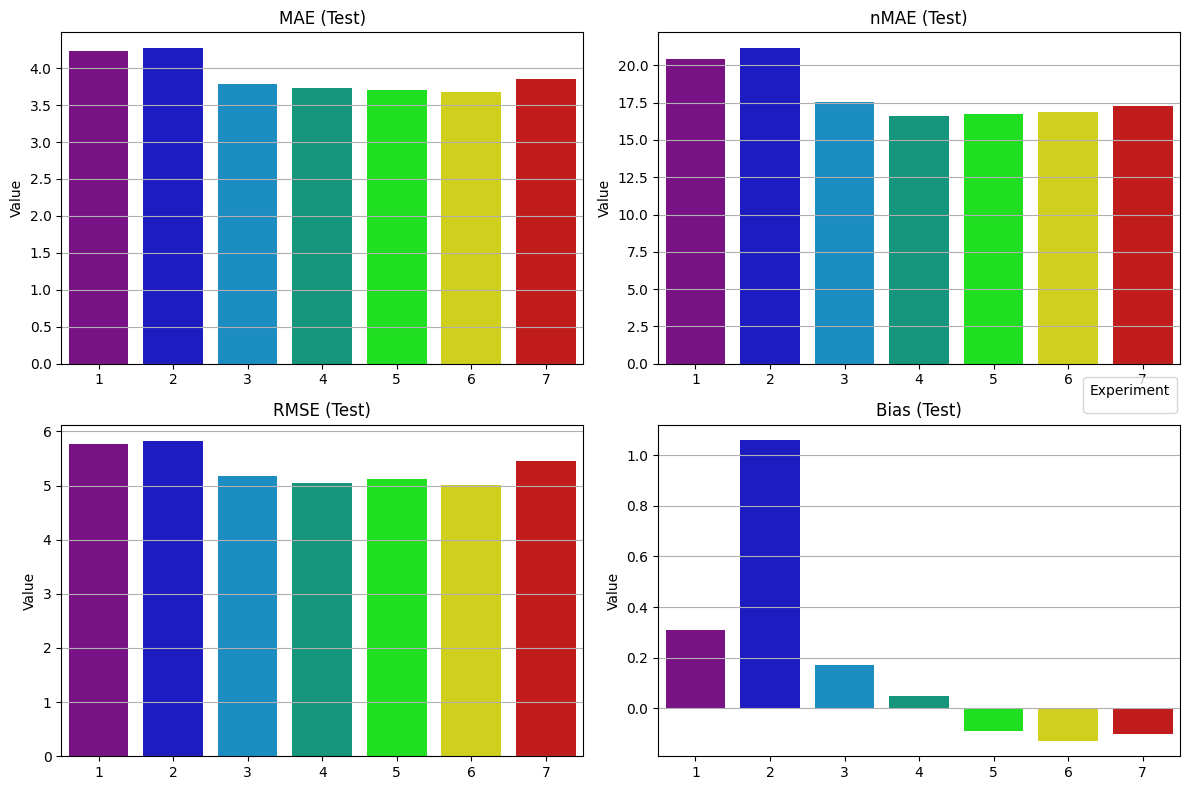

Experiment label mapping: {'01_baseline': '1', '02_pixel_composites': '2', '03_seasonal_composites': '3', '04_pixel_and_seasonal_comp': '4', '05_support_fmask_dlt': '5', '06_support_fmask_dlt_dem': '6', '07_aux_task': '7'}


In [71]:
plot_experiment_metrics_test_only(df)

/var/folders/0s/1cgzkm553c3gm9c4dkbzdh680000gn/T/ipykernel_8505/4137621081.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = get_cmap('nipy_spectral')


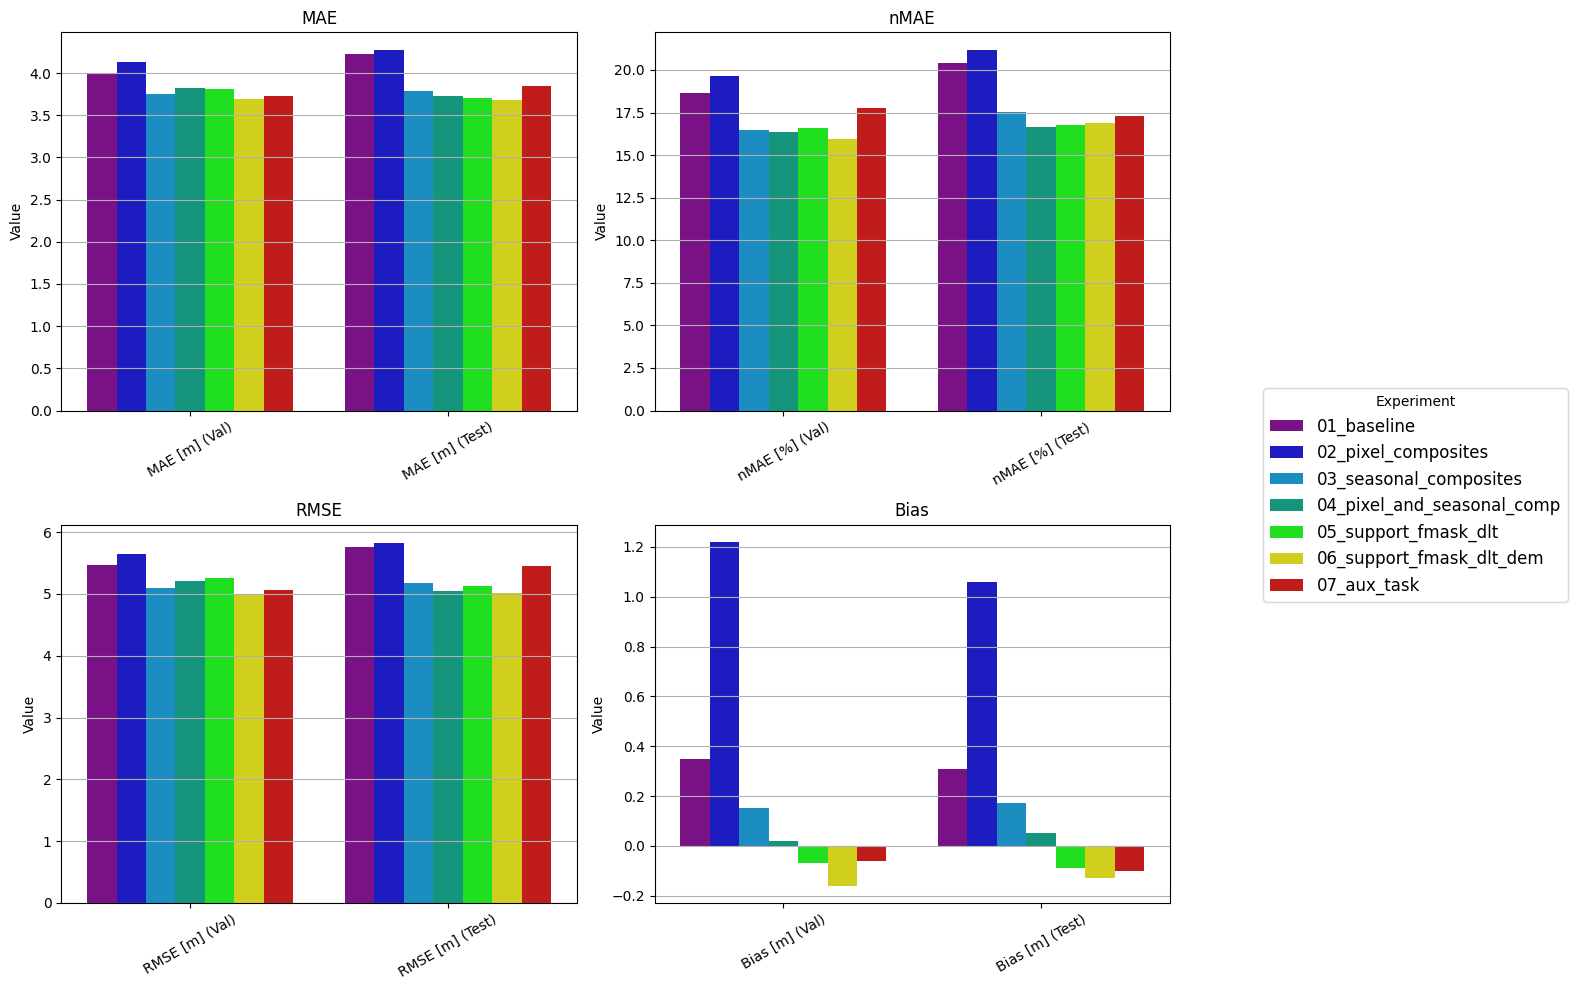

In [72]:
plot_experiment_metrics(df)

In [79]:
def plot_experiment_metrics(df):
    """
    Plot only the Test metrics (MAE, nMAE, RMSE, Bias) for each experiment as grouped barplots,
    hued by experiment name (first column). Discards all Val metrics.
    Args:
        df (pd.DataFrame): DataFrame containing metrics for different experiments.
    """
    metrics = [
        "MAE [m] (Test)",
        "nMAE [%] (Test)",
        "RMSE [m] (Test)",
        "Bias [m] (Test)"
    ]
    metric_labels = ["MAE", "nMAE", "RMSE", "Bias"]

    exp_col = df.columns[0]
    exp_names = df[exp_col].tolist()

    # Define experiment groups and colors
    group_map = {
        0: "Baseline",
        1: "CompositeA",
        2: "CompositeB",
        3: "CompositeC",
        4: "AuxLayerA",
        5: "AuxLayerB",
        6: "MidTraining",
    }
    viridis = get_cmap('nipy_spectral')
    color_indices = [0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.9]
    group_colors = {group: viridis(idx) for group, idx in zip(group_map.values(), color_indices)}

    # Assign experiment group to each experiment (fallback to "Other" if index > map)
    exp_to_group = {exp_names[i]: group_map.get(i, "Other") for i in range(len(exp_names))}
    palette = {exp: group_colors.get(exp_to_group[exp], (0.5, 0.5, 0.5)) for exp in exp_names}

    # Prepare melted dataframe for plotting (only Test metrics)
    df_melted = pd.melt(
        df,
        id_vars=exp_col,
        value_vars=metrics,
        var_name="MetricType",
        value_name="Value"
    )
    # Simplify metric name (MAE, nMAE, ...)
    df_melted["Metric"] = df_melted["MetricType"].apply(lambda x: x.split()[0])
    df_melted["Group"] = df_melted[exp_col].map(exp_to_group)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    handles, labels = None, None
    for i, label in enumerate(metric_labels):
        ax = axes[i // 2, i % 2]
        ax.grid(True, linestyle='--', alpha=0.3)
        metric_group = df_melted[df_melted["Metric"] == label]
        sns.barplot(
            data=metric_group,
            x=exp_col,
            y="Value",
            hue=exp_col,
            ax=ax,
            palette=palette,
            errorbar=None
        )
        ax.set_title(f"{label} (Test)")
        ax.set_xlabel("")
        ax.set_ylabel("Value")
        ax.tick_params(axis='x', rotation=90)
        # capture legend handles once and remove per-axis legends
        if handles is None and labels is None:
            handles, labels = ax.get_legend_handles_labels()
        #ax.get_legend().remove()

    # Global legend on the right
    fig.legend(handles, labels, title="Experiment", loc="center left", bbox_to_anchor=(0.9, 0.5), fontsize='large')
    plt.tight_layout(rect=[0, 0, 0.86, 1])
    plt.show()
    # print mapping for reference
    print("Experiment -> Group mapping:", exp_to_group)


/var/folders/0s/1cgzkm553c3gm9c4dkbzdh680000gn/T/ipykernel_8505/3924682745.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = get_cmap('nipy_spectral')


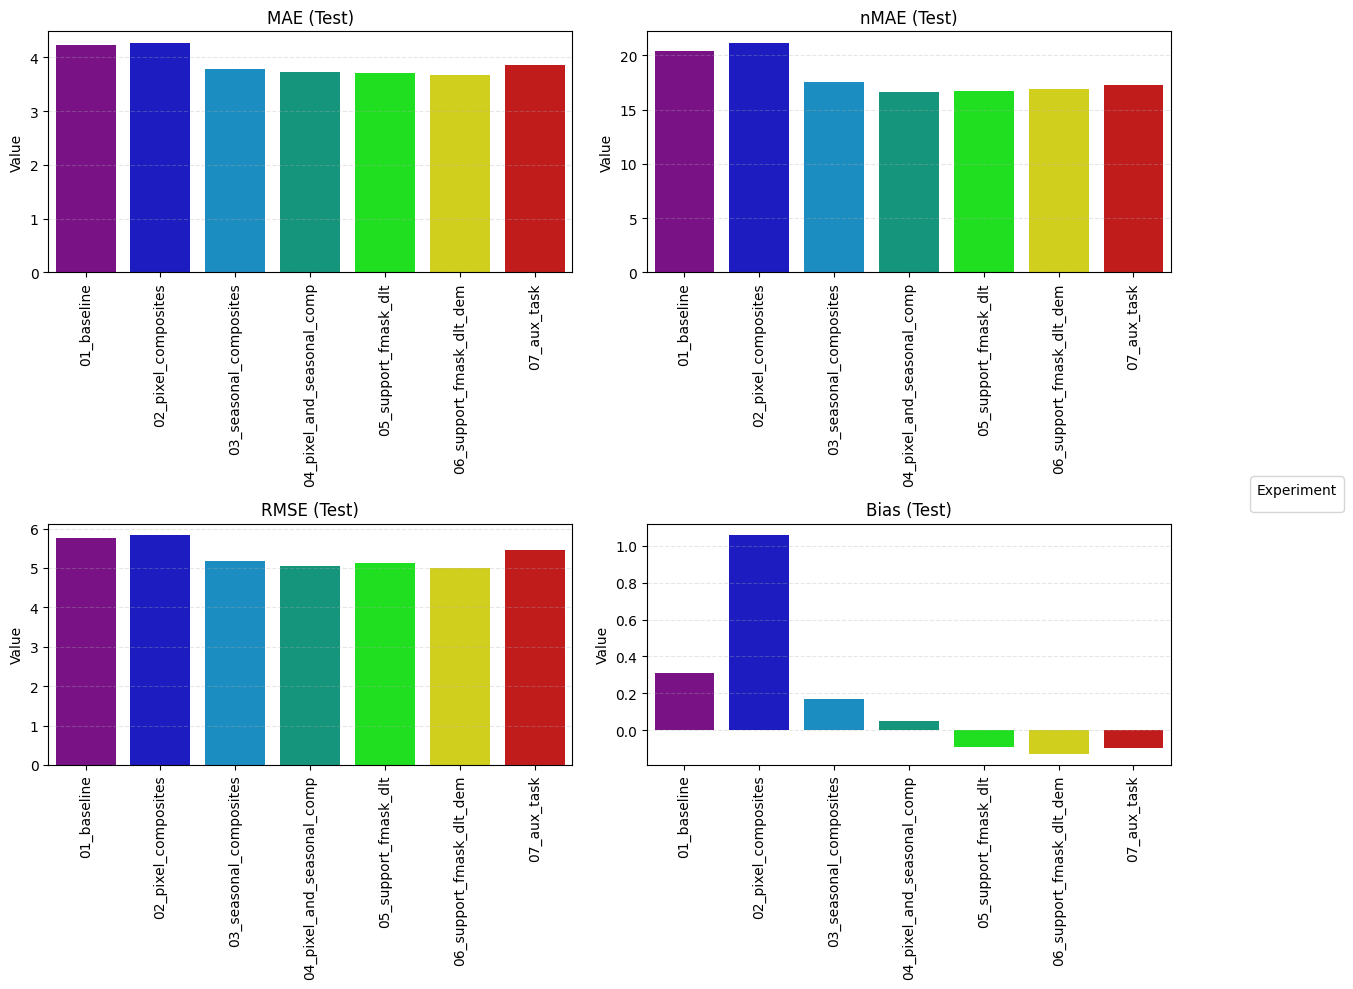

Experiment -> Group mapping: {'01_baseline': 'Baseline', '02_pixel_composites': 'CompositeA', '03_seasonal_composites': 'CompositeB', '04_pixel_and_seasonal_comp': 'CompositeC', '05_support_fmask_dlt': 'AuxLayerA', '06_support_fmask_dlt_dem': 'AuxLayerB', '07_aux_task': 'MidTraining'}


In [80]:
plot_experiment_metrics(df)

## config vizualizer

In [83]:
def plot_experiment_matrix(experiments, order_exps=None, figsize=(14, 6), cmap="Greens"):
  """
  Visualize experiment configs as a binary/config matrix.
  Rows = experiments (index), Columns = features:
    - spectral seasons (prefixed 'season:')
    - spectral quantiles (prefixed 'quantile:')
    - aux inputs (prefixed 'aux:')
    - outputs (prefixed 'out:'; annotated with loss/weight when available)
    - strategy (prefixed 'strategy:')
  A colored cell indicates presence; annotation shows 'x' for simple presence
  or for outputs shows "<loss>|w=<weight>" if available.

  Args:
    experiments (dict): mapping experiment_name -> config dict
    order_exps (list, optional): list of experiment names to control row order
    figsize (tuple): matplotlib figure size
    cmap (str): colormap for seaborn.heatmap
  Returns:
    pd.DataFrame: binary presence matrix (0/1)
  """
  # collect experiment names
  exp_names = list(experiments.keys()) if order_exps is None else order_exps
  # gather all possible columns
  seasons = set()
  quantiles = set()
  aux_inputs = set()
  outputs = set()
  strategies = set()

  for name in exp_names:
    cfg = experiments.get(name, {})
    spec = cfg.get("spectral", {}) or {}
    s = spec.get("seasons", []) or []
    q = spec.get("quantiles", []) or []
    for si in s: seasons.add(si)
    for qi in q: quantiles.add(qi)
    for ai in (cfg.get("aux_inputs") or []): aux_inputs.add(ai)
    for out_name in (cfg.get("outputs") or {}).keys(): outputs.add(out_name)
    strategies.add(cfg.get("strategy", "None"))

  # build ordered column list
  col_list = []
  # strategy columns (one-hot)
  strat_cols = [f"strategy:{s}" for s in sorted(strategies)]
  col_list.extend(strat_cols)
  # spectral
  season_cols = [f"season:{s}" for s in sorted(seasons)]
  quantile_cols = [f"quantile:{q}" for q in sorted(quantiles)]
  col_list.extend(season_cols)
  col_list.extend(quantile_cols)
  # aux inputs
  aux_cols = [f"aux:{a}" for a in sorted(aux_inputs)]
  col_list.extend(aux_cols)
  # outputs
  out_cols = [f"out:{o}" for o in sorted(outputs)]
  col_list.extend(out_cols)

  # prepare matrices
  mat = pd.DataFrame(0, index=exp_names, columns=col_list, dtype=int)
  annot = pd.DataFrame("", index=exp_names, columns=col_list)

  for name in exp_names:
    cfg = experiments.get(name, {}) or {}
    # strategy
    strat = cfg.get("strategy", None)
    if strat is not None:
      col = f"strategy:{strat}"
      if col in mat.columns:
        mat.at[name, col] = 1
        annot.at[name, col] = "x"
    # spectral
    spec = cfg.get("spectral", {}) or {}
    for s in spec.get("seasons", []) or []:
      col = f"season:{s}"
      if col in mat.columns:
        mat.at[name, col] = 1
        annot.at[name, col] = "x"
    for q in spec.get("quantiles", []) or []:
      col = f"quantile:{q}"
      if col in mat.columns:
        mat.at[name, col] = 1
        annot.at[name, col] = "x"
    # aux inputs
    for a in cfg.get("aux_inputs", []) or []:
      col = f"aux:{a}"
      if col in mat.columns:
        mat.at[name, col] = 1
        annot.at[name, col] = "x"
    # outputs: annotate with loss and weight if present
    for out_name, out_cfg in (cfg.get("outputs") or {}).items():
      col = f"out:{out_name}"
      if col in mat.columns:
        mat.at[name, col] = 1
        loss = out_cfg.get("loss")
        weight = out_cfg.get("weight")
        if loss is None and weight is None:
          annot.at[name, col] = "x"
        else:
          pieces = []
          if loss is not None:
            pieces.append(str(loss))
          if weight is not None:
            pieces.append(f"w={weight}")
          annot.at[name, col] = "|".join(pieces)

  # Plot with seaborn heatmap and string annotations
  import seaborn as sns  # seaborn is available in notebook; import again is harmless
  plt.figure(figsize=figsize)
  ax = sns.heatmap(mat, cmap=cmap, cbar=False, linewidths=0.5, linecolor="#dddddd",
           annot=annot.values, fmt="", annot_kws={"fontsize": 9}, vmin=0, vmax=1)
  ax.set_ylabel("")  # experiments are rows already
  ax.set_xlabel("")  # columns explain themselves
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
  plt.title("Experiment configuration mapping (x = present; outputs show loss|w=weight)")
  plt.tight_layout()
  plt.show()

  return mat

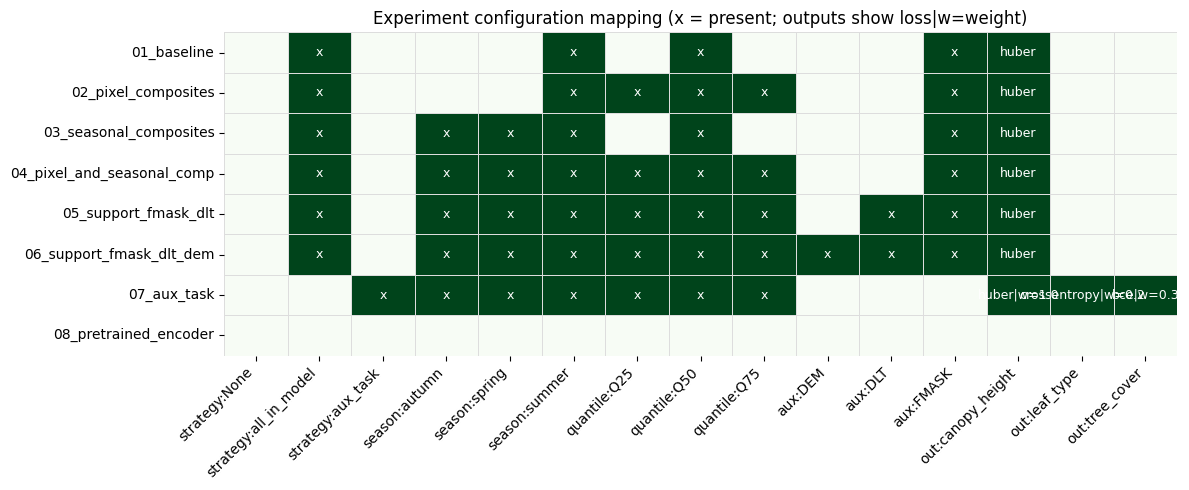

,strategy:None,strategy:all_in_model,strategy:aux_task,season:autumn,season:spring,season:summer,quantile:Q25,quantile:Q50,quantile:Q75,aux:DEM,aux:DLT,aux:FMASK,out:canopy_height,out:leaf_type,out:tree_cover
01_baseline,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0
02_pixel_composites,0,1,0,0,0,1,1,1,1,0,0,1,1,0,0
03_seasonal_composites,0,1,0,1,1,1,0,1,0,0,0,1,1,0,0
04_pixel_and_seasonal_comp,0,1,0,1,1,1,1,1,1,0,0,1,1,0,0
05_support_fmask_dlt,0,1,0,1,1,1,1,1,1,0,1,1,1,0,0
06_support_fmask_dlt_dem,0,1,0,1,1,1,1,1,1,1,1,1,1,0,0
07_aux_task,0,0,1,1,1,1,1,1,1,0,0,0,1,1,1
08_pretrained_encoder,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [84]:
plot_experiment_matrix(experiments, figsize=(12, 5), cmap="Greens")

## scribblsz

In [146]:
preds_val, targets_val, preds_test, targets_test, maskval, masktest = md.load_np_stacks('pixel_and_seasonal')

In [281]:
print(f"Shape of preds_val: {preds_val.shape}")
print(f"Shape of targets_val: {targets_val.shape}")
print(f"Shape of preds_test: {preds_test.shape}")
print(f"Shape of targets_test: {targets_test.shape}")
print(f"Shape of maskval: {maskval.shape}")
print(f"Shape of masktest: {masktest.shape}")

Shape of preds_val: (181, 3, 32, 32)
Shape of targets_val: (181, 3, 32, 32)
Shape of preds_test: (182, 3, 32, 32)
Shape of targets_test: (182, 3, 32, 32)
Shape of maskval: (181, 1, 32, 32)
Shape of masktest: (182, 1, 32, 32)


In [133]:
maskval[:,0,:,:] = maskval[:,0,:,:].astype(np.float32)

In [157]:
preds_test[:,0,:,:].min()

np.float32(22.851805)

In [80]:
cfg["strategy"]

'mid_level'

In [45]:
mu = sites['SITE2']['CHM_norm_params']['mu']
std = sites['SITE2']['CHM_norm_params']['std']


In [34]:
report["experiment_name"]

'baseline'

In [31]:
def save_results(model, val_loader, test_loader, normparams, logs, cfg):

    out_dir = os.path.join("../results/train", cfg['exp'])
    os.makedirs(out_dir, exist_ok=True)

    # Save model weights
    torch.save(model.state_dict(), os.path.join(out_dir, "model.pth"))

    # Save logs and cfg as JSON
    with open(os.path.join(out_dir, "logs.json"), "w") as f:
        json.dump(logs, f)
    with open(os.path.join(out_dir, "cfg.json"), "w") as f:
        json.dump(cfg, f)

    # Optionally, save predictions and targets for val/test sets
    preds_val, targets_val = get_predictions_and_targets(val_loader, model, normparams)
    preds_test, targets_test = get_predictions_and_targets(test_loader, model, normparams)

    # Zip predictions and targets for val/test sets and save as .npz files
    np.savez(os.path.join(out_dir, "val_preds_targets.npz"), preds_val=preds_val, targets_val=targets_val)
    np.savez(os.path.join(out_dir, "test_preds_targets.npz"), preds_test=preds_test, targets_test=targets_test)

    print("Results saved to:", out_dir)

def load_np_stacks(exp_dir):
    """
    Loads prediction and target numpy arrays from the experiment results folder.
    Returns preds_val, targets_val, preds_test, targets_test as numpy arrays.
    """
    out_dir = os.path.join("../results/train", exp_dir)
    val_npz = np.load(os.path.join(out_dir, "val_preds_targets.npz"))
    test_npz = np.load(os.path.join(out_dir, "test_preds_targets.npz"))
    preds_val = val_npz["preds_val"]
    targets_val = val_npz["targets_val"]
    preds_test = test_npz["preds_test"]
    targets_test = test_npz["targets_test"]
    return preds_val, targets_val, preds_test, targets_test

def load_results(exp_dir):
    """
    Loads model weights, logs, and cfg from the experiment results folder.
    """
    out_dir = os.path.join("../results/train", exp_dir)
    model_weights = torch.load(os.path.join(out_dir, "model.pth"))
    with open(os.path.join(out_dir, "logs.json"), "r") as f:
        logs = json.load(f)
    with open(os.path.join(out_dir, "cfg.json"), "r") as f:
        cfg = json.load(f)
    return model_weights, logs, cfg

def ziptheresults(exp_name, model_weights, logs, cfg, preds_val, targets_val, preds_test, targets_test):
    """
    Compile a new evaluation report for the given experiment.
    """
    report = {
        "experiment_name": exp_name,
        "model_weights": model_weights,
        "logs": logs,
        "config": cfg,
        "predictions": {
            "validation": preds_val,
            "test": preds_test
        },
        "targets": {
            "validation": targets_val,
            "test": targets_test
        }
    }
    return report